In [1]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, CuDNNLSTM

In [2]:
class RNN:
    def __str__(self):
        self.model.summary()
        return ""
    
    def __repr__(self):
        self.model.summary()
        return ""
    
    def __init__(self, input_size, time_steps, output_size, dropout=0.4):
        self.model = self.generate_model(input_size, output_size, time_steps, dropout)
        
    def generate_model(self, input_size, output_size, time_steps, dropout):
        input_layer = Input((1,input_size))
        
        lstm_layer = CuDNNLSTM(64, return_sequences=True)(input_layer)
        lstm_layer = Dropout(dropout)(lstm_layer)
        lstm_layer = CuDNNLSTM(64)(input_layer)
        lstm_layer = Dropout(dropout)(lstm_layer)
        
        output_layer = Dense(output_size*time_steps, activation='tanh')(lstm_layer)
        
        model = Model(input_layer, output_layer)
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
        return model
    
    def train(self, input_data, output_data, batch_size=32, epochs=10):
        self.model.fit(input_data, output_data, batch_size=batch_size, epochs=epochs)
        
    def predict(self,input_data):
        return self.model.predict(input_data)

In [3]:
def threeBody(y, t, M):
    equations = np.empty((12, ))
    
    # Radii
    R12 = np.sqrt((y[0]-y[4])**2+(y[1]-y[5])**2)
    R13 = np.sqrt((y[0]-y[8])**2+(y[1]-y[9])**2)
    R23 = np.sqrt((y[4]-y[8])**2+(y[5]-y[9])**2)
    
    # Mass 0
    equations[0] = y[2]
    equations[1] = y[3]
    equations[2] = G*M[1]*(y[4]-y[0])/(R12**3)+G*M[2]*(y[8]-y[0])/(R13**3)
    equations[3] = G*M[1]*(y[5]-y[1])/(R12**3)+G*M[2]*(y[9]-y[1])/(R13**3)
    
    # Mass 1
    equations[4] = y[6]
    equations[5] = y[7]
    equations[6] = G*M[0]*(y[0]-y[4])/(R12**3)+G*M[2]*(y[8]-y[4])/(R23**3)
    equations[7] = G*M[0]*(y[1]-y[5])/(R12**3)+G*M[2]*(y[9]-y[5])/(R23**3)
    
    # Mass 2
    equations[8] = y[10]
    equations[9] = y[11]
    equations[10] = G*M[0]*(y[0]-y[8])/(R13**3)+G*M[1]*(y[4]-y[8])/(R23**3)
    equations[11] = G*M[0]*(y[1]-y[9])/(R13**3)+G*M[1]*(y[5]-y[9])/(R23**3)
    
    return equations

In [4]:
def get_sample():
    # Random Initial Values 
    M = np.random.rand(3) # 3 Masses
    Y0 = np.random.rand(12) * 2 - np.ones(12) # [x,y,vx,vy]
    T = np.linspace(0, MAX_TIME, TIME_STEPS) # Time Range
    
    solution = odeint(threeBody, Y0, T, (M, )) # DE Solver (RK45)
    sol = np.array(solution[:,[0,1,4,5,8,9]]) # Picking position columns.
    
    return np.concatenate((M, Y0 * SCALE)) , sol * SCALE # Scale to prevent overlap.

In [5]:
def get_training_data(sample):
    
    IV = [] # Initial values for training.
    solution = [] # Paths generated by RK 45.
    
    for _ in range(sample):
        i, s = get_sample()
        IV.append(i)
        solution.append(s)
    return np.array(IV).reshape(-1, 1, INPUT_SIZE), np.array(solution).reshape(-1, TIME_STEPS*OUTPUT_SIZE)

In [6]:
# Physics Constants
G = 0.6674
DT = 0.001

# Training Constants
SCALE = 0.1
NUMBER_OF_SAMPLES = 100
MAX_TIME = 0.01
TIME_STEPS = int(MAX_TIME * 1/DT)

#RNN Constants
INPUT_SIZE = 15
OUTPUT_SIZE = 6

In [7]:
train, label = get_training_data(NUMBER_OF_SAMPLES)

In [8]:
rnn = RNN(input_size=15, output_size=6, time_steps=TIME_STEPS)

In [10]:
rnn.train(train, label, batch_size=10, epochs=20)

Epoch 1/20
100/100 [==============================] - 0s 1ms/step - loss: 0.0032 - acc: 0.0500
Epoch 2/20
100/100 [==============================] - 0s 1ms/step - loss: 0.0032 - acc: 0.0300
Epoch 3/20
100/100 [==============================] - 0s 1ms/step - loss: 0.0031 - acc: 0.0500
Epoch 4/20
100/100 [==============================] - 0s 1ms/step - loss: 0.0031 - acc: 0.0300
Epoch 5/20
100/100 [==============================] - 0s 2ms/step - loss: 0.0030 - acc: 0.0400
Epoch 6/20
100/100 [==============================] - 0s 2ms/step - loss: 0.0030 - acc: 0.0500
Epoch 7/20
100/100 [==============================] - 0s 1ms/step - loss: 0.0029 - acc: 0.0400
Epoch 8/20
100/100 [==============================] - 0s 1ms/step - loss: 0.0028 - acc: 0.0600
Epoch 9/20
100/100 [==============================] - 0s 1ms/step - loss: 0.0027 - acc: 0.0700
Epoch 10/20
100/100 [==============================] - 0s 1ms/step - loss: 0.0026 - acc: 0.0400
Epoch 11/20
100/100 [============================

In [11]:
paths = label.reshape(-1,TIME_STEPS,OUTPUT_SIZE)*1/SCALE

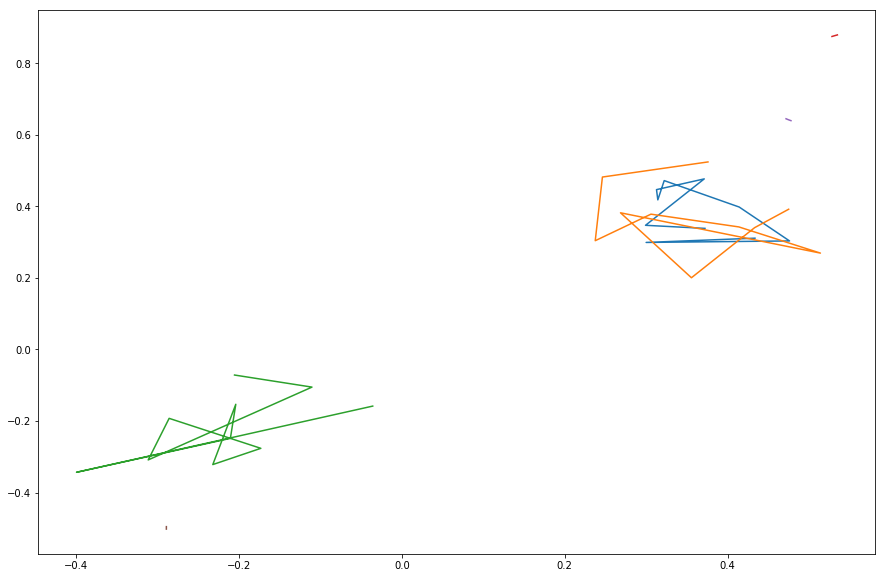

In [12]:
test_index = 1
test_path = rnn.predict(train[test_index][0].reshape(-1, 1, INPUT_SIZE)).reshape(-1,OUTPUT_SIZE)*1/SCALE

plt.figure(figsize=(15,10))
plt.plot(test_path[:,0], test_path[:,1])
plt.plot(test_path[:,2], test_path[:,3])
plt.plot(test_path[:,4], test_path[:,5])
plt.plot(paths[test_index][:,0], paths[test_index][:,1])
plt.plot(paths[test_index][:,2], paths[test_index][:,3])
plt.plot(paths[test_index][:,4], paths[test_index][:,5])
plt.show()